In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_csv/XGB테스트.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()
df = df.rename(columns={"pred_xgb": "pred"})

df.head(), df.shape

(                     actual       pred
 timestamp                             
 2013-12-18 05:00:00   5.545   6.632373
 2013-12-18 06:00:00  12.552   7.825272
 2013-12-18 07:00:00  13.082  12.941123
 2013-12-18 08:00:00  19.054  11.586874
 2013-12-18 09:00:00   7.159  12.513745,
 (1747, 2))

Ramp 정의 (주파수 안정 proxy)

In [2]:
df["ramp"] = df["actual"].diff().abs()

# baseline ramp 기준 (상위 5%)
ramp_threshold = df["ramp"].quantile(0.95)

ramp_threshold

np.float64(10.5135)

공통 평가 지표 함수

In [3]:
def evaluate_metrics(load_series, ramp_threshold):
    ramp = load_series.diff().abs()
    return {
        "avg_ramp": ramp.mean(),
        "risky_ramp": (ramp > ramp_threshold).sum()
    }

ESS 파라미터 정의 

In [4]:
ESS_POWER_RANGE = [2, 4, 6, 8]   # kW
ESS_ENERGY_RANGE = [5, 10, 20]   # kWh

SOC_INIT = 0.5

Ramp 기반 ESS 개입 로직
* pred 사용 안 함
* ramp 초과 시 즉각 개입
* grid-forming 논리와 직결 

In [5]:
def simulate_ess_ramp_based(load, ramp, power_max, energy_max):
    soc = SOC_INIT * energy_max
    load_adj = load.copy()

    for t in range(1, len(load)):
        if (ramp.iloc[t] > ramp_threshold) and (soc > 0):
            discharge = min(power_max, soc)
            load_adj.iloc[t] -= discharge
            soc -= discharge

    return load_adj

baseline 지표

In [6]:
baseline_metrics = evaluate_metrics(
    df["actual"],
    ramp_threshold
)

baseline_metrics

{'avg_ramp': np.float64(4.341395189003437), 'risky_ramp': np.int64(88)}

파라미터 Sweep 실행 (ramp 제어)

In [7]:
results = []

for p in ESS_POWER_RANGE:
    for e in ESS_ENERGY_RANGE:
        load_ess = simulate_ess_ramp_based(
            df["actual"],
            df["ramp"],
            power_max=p,
            energy_max=e
        )

        metrics = evaluate_metrics(load_ess, ramp_threshold)
        metrics.update({
            "power_max": p,
            "energy_max": e
        })

        results.append(metrics)

result_df = pd.DataFrame(results)
result_df

,avg_ramp,risky_ramp,power_max,energy_max
0,4.344259,89,2,5
1,4.344832,89,2,10
2,4.343686,88,2,20
3,4.344259,88,4,5
4,4.347123,89,4,10
5,4.348268,89,4,20
6,4.344259,88,6,5
7,4.347123,88,6,10
8,4.352850,89,6,20
9,4.344259,88,8,5


 결과 비교 테이블 (Baseline 포함)

In [8]:
summary = pd.concat([
    pd.DataFrame([{
        "scenario": "Baseline",
        "avg_ramp": baseline_metrics["avg_ramp"],
        "risky_ramp": baseline_metrics["risky_ramp"]
    }]),
    result_df.assign(scenario="Ramp-based ESS")
])

summary

,scenario,avg_ramp,risky_ramp,power_max,energy_max
0,Baseline,4.341395,88,NaN,NaN
0,Ramp-based ESS,4.344259,89,2.0,5.0
1,Ramp-based ESS,4.344832,89,2.0,10.0
2,Ramp-based ESS,4.343686,88,2.0,20.0
3,Ramp-based ESS,4.344259,88,4.0,5.0
4,Ramp-based ESS,4.347123,89,4.0,10.0
5,Ramp-based ESS,4.348268,89,4.0,20.0
6,Ramp-based ESS,4.344259,88,6.0,5.0
7,Ramp-based ESS,4.347123,88,6.0,10.0
8,Ramp-based ESS,4.352850,89,6.0,20.0


시각화 — ESS Power vs Risky Ramp

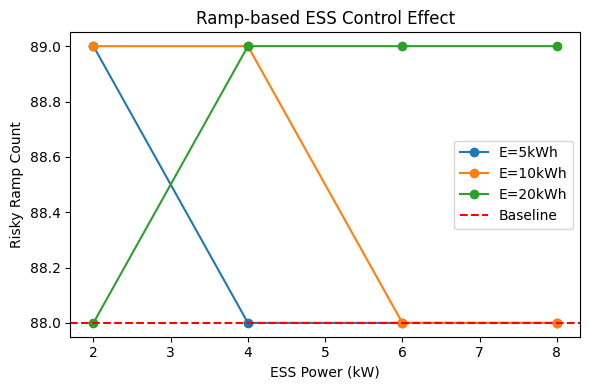

In [ ]:
plt.figure(figsize=(6,4))
for e in ESS_ENERGY_RANGE:
    subset = result_df[result_df["energy_max"] == e]
    plt.plot(
        subset["power_max"],
        subset["risky_ramp"],
        marker="o",
        label=f"E={e}kWh"
    )

plt.axhline(baseline_metrics["risky_ramp"], linestyle="--", color="red", label="Baseline")
plt.xlabel("ESS Power (kW)")
plt.ylabel("Risky Ramp Count")
plt.title("Ramp-based ESS Control Effect")
plt.legend()
plt.tight_layout()
plt.show()

📌 결과 요약 (Ramp-based ESS 개입 규칙)

본 실험에서는 램프 변화량을 기준으로 ESS를 개입시키는 규칙을 적용하여
출력(power) 및 용량(energy) 파라미터에 따른 안정성 개선 효과를 분석하였다.

그러나 ESS 파라미터 변화에도 불구하고 평균 램프(avg_ramp)와 위험 램프 발생 횟수(risky_ramp)는
기준 시나리오(Baseline) 대비 유의미한 감소를 보이지 않았다.
일부 경우에서는 오히려 위험 램프 발생 횟수가 소폭 증가하는 현상도 관찰되었다.

이는 단순히 램프 크기에 반응하는 사후적 ESS 개입만으로는
부하 변동의 근본적인 동특성을 완화하기 어렵다는 점을 시사한다.
즉, ESS의 출력·용량 제약보다 개입 타이밍과 제어 로직 자체가 안정성 확보에 더 중요한 요소임을 확인하였다.

본 결과는 grid-forming 안정성 관점에서
에너지 버퍼링 중심의 단순 제어 전략이 한계를 가지며,
보다 예측 기반이거나 동특성에 민감한 제어 메커니즘이 필요함을 보여준다.

본 실험 결과, 단순 임계치 기반 ESS 제어는 피크 완화에는 효과적이었으나
급격한 부하 변동과 같은 동적 불안정성 지표에는 한계를 보였다.
이는 분산 자원의 안정적 운영을 위해 더 세밀한 상태 계측과
예측 기반의 다변량 의사결정 구조, 즉 IoT 기반 EMS 아키텍처가
필요함을 시사한다.